In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

assert pyro.__version__.startswith('1.8.1')
pyro.set_rng_seed(0)

In [2]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

In [5]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", Normal(torch.zeros(1), torch.ones(1)).to_event(1))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta))) 
        pyro.sample("obs", Normal(mu[z], torch.ones(1)).to_event(1), obs=data)

def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda:  Normal(torch.zeros(1), torch.ones(1)).sample([T]))
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", Normal(tau, torch.ones(1)).to_event(1)) 

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi)) 

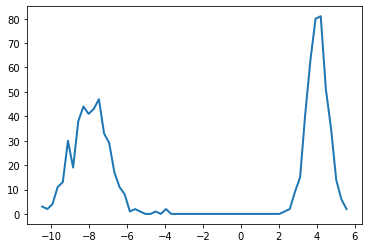

In [3]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')

data = torch.cat((dist.Normal(-8, 1).sample([400]),dist.Normal(4, 0.5).sample([400])))
hist, bin_edges = np.histogram(data, bins=60)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
plt.plot(bin_centers, hist, lw=2)


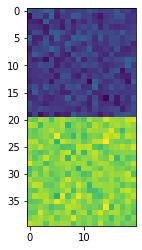

In [4]:
data = ndimage.gaussian_filter(data, sigma=0.5)

mask = (data > data.mean()).astype(np.float)

data = mask + 0.1*np.random.randn(*mask.shape)
plt.imshow(np.reshape(data, (40,20)))

In [6]:
T = 2
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(num_iterations, d):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(d)
        losses.append(loss)

alpha = 0.01
data = torch.reshape(torch.tensor(data), (-1,))
N = data.shape[0]

train(1000,data)

100%|██████████| 1000/1000 [00:26<00:00, 37.14it/s]


In [7]:
def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 450.
    true_centers = centers[weights > threshold] # remove clusters which have a too small probability
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold]) # re-normalize weights so that they sum to one
    
    idx_kept = torch.topk(weights, true_centers.shape[0])[1]
    return true_centers, true_weights, idx_kept
    
true_centers, true_weights, idx_kept = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

In [8]:
assignment = [torch.argmax(i) for i in pyro.param("phi").detach()[:,list(idx_kept)]]

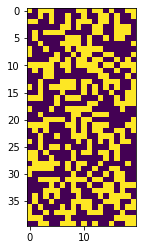

In [15]:
col = [0,1,2,3]

clusts = []

for i in assignment:
    clusts.append(col[i])

plt.imshow(np.reshape(clusts, (40,20)))
#plt.imshow(torch.rand(256,256)*0)